In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack", url, untar=True, cache_dir='.', cache_subdir='')

6053168/6053168 [==============================] - 0s 0us/step


In [5]:
dataset_dir = '/content'
os.listdir(dataset_dir)


['.config', 'README.md', 'test', 'train', 'stack.tar.gz', 'sample_data']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'python', 'javascript', 'java']

In [ ]:
# sample_file = os.path.join(dataset_dir, 'pos/1181_9.txt')
# with open(sample_file) as f:
#   print(f.read())

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_Ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [10]:
for text_batch, label_batch in raw_train_Ds.take(1):
  for i in range(3):
    print(f"Review: {len(text_batch.numpy()[i])}", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review: 2480 b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default c

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [16]:
train_text = raw_train_Ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
text_batch, label_batch = next(iter(raw_train_Ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_Ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [19]:
train_ds = raw_train_Ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model=tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [23]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
epochs = 10
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/10
200/200 [==============================] - 28s 115ms/step - loss: 1.3801 - accuracy: 0.3411 - val_loss: 1.3697 - val_accuracy: 0.4256
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3531 - accuracy: 0.4534 - val_loss: 1.3330 - val_accuracy: 0.5456
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3048 - accuracy: 0.5231 - val_loss: 1.2763 - val_accuracy: 0.5612
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2389 - accuracy: 0.5698 - val_loss: 1.2077 - val_accuracy: 0.6031
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 1.1664 - accuracy: 0.6061 - val_loss: 1.1359 - val_accuracy: 0.6506
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0906 - accuracy: 0.6619 - val_loss: 1.0659 - val_accuracy: 0.6938
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0196 - accuracy: 0.7000 - val_loss: 1.0013 - val_accuracy: 0.7212
Epo

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.8739 - accuracy: 0.7380
Loss:  0.8738691806793213
Accuracy:  0.7379999756813049


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

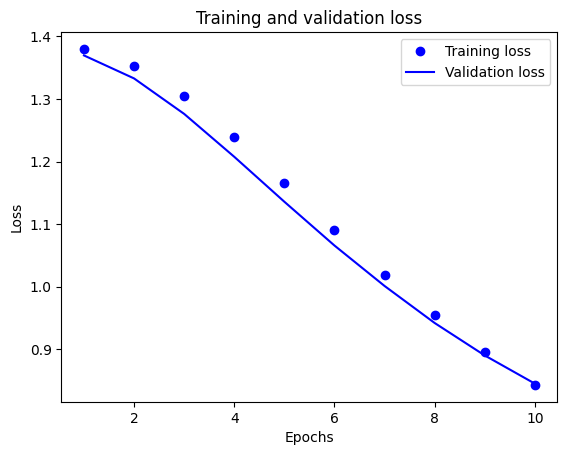

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

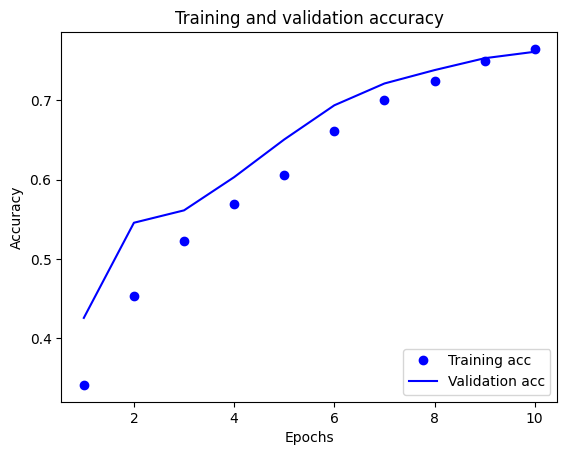

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [30]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [31]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 9ms/step - loss: 0.8739 - accuracy: 0.7380
0.7379999756813049


In [42]:
import numpy as np

In [55]:
examples =[]
expected = []
for text_batch, label_batch in raw_train_Ds.take(1):
  for j in range(10):
    examples.append(text_batch.numpy()[j])
    expected.append(raw_train_Ds.class_names[label_batch.numpy()[j]])

model = []
ans = export_model.predict(examples)

for i in ans:
  model.append(raw_train_Ds.class_names[np.argmax(i)])

for answers in range(10):
  print(f'Expected: {expected[answers]}   |   Model:{model[answers]} {"::" if expected[answers] == model[answers] else ""}')

1/1 [==============================] - 0s 32ms/step
Expected: javascript   |   Model:csharp 
Expected: csharp   |   Model:csharp ::
Expected: csharp   |   Model:csharp ::
Expected: python   |   Model:python ::
Expected: java   |   Model:csharp 
Expected: python   |   Model:python ::
Expected: javascript   |   Model:javascript ::
Expected: java   |   Model:java ::
Expected: python   |   Model:python ::
Expected: csharp   |   Model:csharp ::
